In [1]:
import torch
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score, mean_squared_error

from model import *
from utils import *

In [2]:
train_data_num = 10000
test_data_num = 1000000

In [3]:
model = MLP()
model.cuda()
model

MLP(
  (layers): Sequential(
    (0): Linear(in_features=3, out_features=1000, bias=True)
    (1): ReLU()
    (2): Linear(in_features=1000, out_features=1000, bias=True)
    (3): ReLU()
    (4): Linear(in_features=1000, out_features=1, bias=True)
  )
)

In [4]:
net_dir = 'net'
model.load_state_dict( torch.load(f'net/bs_net_{train_data_num:.0e}.pt') )

<All keys matched successfully>

In [5]:
loader_test = make_loader_test(test_data_num)   

In [6]:
def bs_call_tv(vol, K, T) :
    d1 = (torch.log(1./K) + (0.5 * vol ** 2) * T) / (vol * torch.sqrt(T))
    d2 = d1 - vol * torch.sqrt(T)
    normal_dist = Normal(0, 1)
    option_price = normal_dist.cdf(d1) - K * normal_dist.cdf(d2)
    option_price = option_price - torch.relu(1.-K)
    return torch.relu(option_price)

In [7]:
tmp1 = []; tmp2 = []; tmp3 = []
for i,(x,y) in enumerate(loader_test) :
    
    x = x.cuda(); y = y.cuda()
    with torch.no_grad() :
        y_pred = model(x)
    tmp1.append(y_pred)
    tmp2.append(y)
        
    vol,K,T=np.split(x,3,axis=1)
    K = torch.exp( K*vol*torch.sqrt(T) )
    y_true = bs_call_tv(vol,K,T)
    tmp3.append(y_true)

y_pred = torch.vstack(tmp1).cpu().numpy()
y = torch.vstack(tmp2).cpu().numpy()
y_true = torch.vstack(tmp3).cpu().numpy()

df = pd.DataFrame( np.concatenate([y_pred,y,y_true],axis=1), columns = ['y_pred','y','y_true'] )
print(df)
print('')

          y_pred         y    y_true
0       0.018859  0.018680  0.018692
1       0.020032  0.020562  0.020644
2       0.004163  0.003507  0.003988
3       0.017697  0.016653  0.016372
4       0.131284  0.133780  0.133804
...          ...       ...       ...
999995  0.129251  0.129081  0.128604
999996  0.003594  0.003417  0.003572
999997  0.004908  0.004783  0.004920
999998  0.071978  0.072951  0.072712
999999  0.020494  0.020368  0.020594

[1000000 rows x 3 columns]



R2: 9.99681e-01, MSE: 9.15651e-07, TEST_LOSS: 2.10116e-06


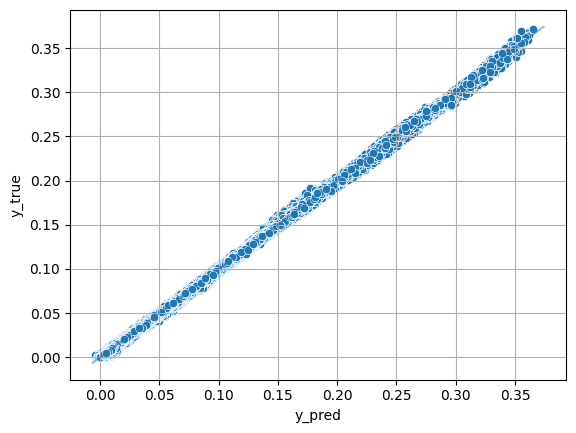

R2: 9.99681e-01


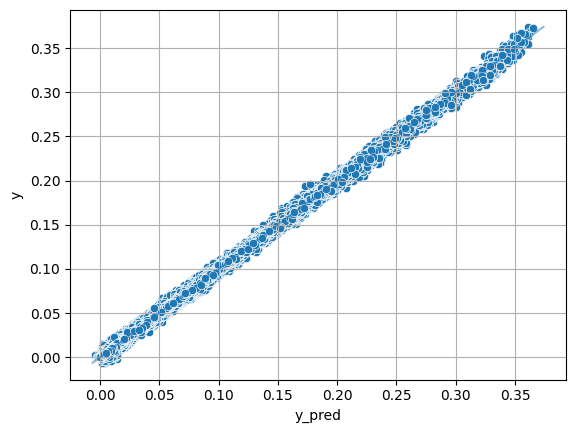

R2: 9.99268e-01


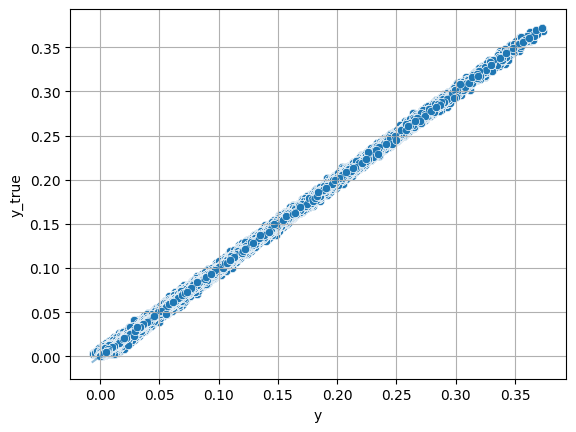

R2: 9.99586e-01


In [8]:
r2 = r2_score(y_pred,y_true)
mse = mean_squared_error(y_pred,y_true)
test_mse = mean_squared_error(y_pred,y)
print(f'R2: {r2:.5e}, MSE: {mse:.5e}, TEST_LOSS: {test_mse:.5e}')

xx = np.linspace(np.min(y),np.max(y),101)

plt.plot(xx,xx,c='C0',alpha=0.5)
sns.scatterplot(df,x='y_pred',y='y_true')
plt.grid()
plt.show()
r2 = r2_score(y_pred,y_true)
print(f'R2: {r2:.5e}')

plt.plot(xx,xx,c='C0',alpha=0.5)
sns.scatterplot(df,x='y_pred',y='y')
plt.grid()
plt.show()
r2 = r2_score(y_pred,y)
print(f'R2: {r2:.5e}')

plt.plot(xx,xx,c='C0',alpha=0.5)
sns.scatterplot(df,x='y',y='y_true')
plt.grid()
plt.show()
r2 = r2_score(y,y_true)
print(f'R2: {r2:.5e}')